#### This function is useful if you do a lot of work with facial images and need to crop the image to just the face. 
The source_dir is the directory where the image files you want to crop should be stored. The dest_dir is the directory where the cropped images will be stored. If it does not exist the function will create the directory. The function has 2 modes of operation. When mode=1 the function will input the images sequentially. For each image it will detect the faces in the image. It will save only the LARGEST face in the image. If mode is not 1, the function detects all the facial images in the image final and crops and returns all of them. For example if an image called nurses.jpg has 3 facial images in it, the function will crop and save all three to the destination directory. They would be lavelled as nurses0.jpg, nurses1.jpg and nurses2,jpg. If the function does not find a facial image in the input image, it adds the name to the uncropped_file_list which is returned by the function. Parameter min_img_size is an integer that specifies the minimum dimension (height and width) a cropped image must have in order to be saved in the dest_dir. Please note the MTCNN module is not flawless. You should always check the cropped images visually to ensure they are correct.

In [1]:
from mtcnn import MTCNN
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

In [2]:
def crop_image(source_dir, dest_dir, mode, min_img_size):    
    if os.path.isdir(dest_dir)==False:
        print('The destination directory ', dest_dir,  ' does not exist. Creating it for you')
        os.mkdir(dest_dir)
    # empty the dest_dir of any files
    dest_list=os.listdir(dest_dir)
    if len(dest_list) !=0:
        cycle=True
        print ('The destination directory contains ', len(dest_list), 'files')
        while cycle:            
            ans=input ('Enter D to delete the files, Q to quit the process or K to keep the files and continue')
            if ans == 'Q' or ans == 'q':
                print ('**** PROCESS TERMINATED *****')
                return False, None, None, None
            if ans == 'D' or ans == 'd':
                print( 'removing ', len(dest_list), ' files from ', dest_dir)
                for f in dest_list:
                    f_path=os.path.join(dest_dir,f)
                    os.remove (f_path)
                    cycle=False
            elif ans=='K' or ans =='k':
                print (' cropped images will be appended to the contents of ', dest_dir)
                cycle=False
            else:
                print(' your response ', ans, ' was neither Q, D, or K - try again') 
    
    detector = MTCNN()
    source_list=os.listdir(source_dir)
    if len(source_list) ==0:
        print ('there are no files in ', source_dir, ' ***** PROCESSS TERMINATING *****')
        return False, None, None,None
    # process the contents of the source directory file list        
    uncropped_file_list=[] 
    to_small_list=[]
    no_face_list = []
    processed=0
    good=0
    bad=0
    for f in tqdm(source_list):
        f_path=os.path.join(source_dir, f)
        if os.path.isdir(f_path)==True:
            print('The source directory ', source_dir, ' contains sub directories these will be ignored')
        else:
            skip=False
            processed=processed + 1 
            dest_path=os.path.join(dest_dir,f)
            try:
                img=cv2.imread(f_path)
                dummy=img.size
                data=detector.detect_faces(img)
                if data ==[]:
                    uncropped_file_list.append(f_path)
                    no_face_list.append(f_path)
                    bad=bad+1
                    skip=True
                else: 
                    one_good=False
                    for faces in data:
                        box=faces['box']
                        if box[2]>=min_img_size and box[3]>=min_img_size:
                            one_good=True                        
                    if  one_good==False:
                        uncropped_file_list.append(f_path)
                        bad=bad+1
                        to_small_list.append (f_path)
                        skip=True
                if skip==False:
                    if mode==1:  #detect the box with the largest area
                        for i, faces in enumerate(data): # iterate through all the faces found
                            box=faces['box']  # get the box for each face
                            biggest=0                    
                            area = box[3]  * box[2]
                            if area>biggest:
                                biggest=area
                                bbox=box 
                            bbox[0]= 0 if bbox[0]<0 else bbox[0]
                            bbox[1]= 0 if bbox[1]<0 else bbox[1]
                            img=img[bbox[1]: bbox[1]+bbox[3],bbox[0]: bbox[0]+ bbox[2]] 
                            cv2.imwrite(dest_path, img)
                            good=good +1
                                                            
                    else:
                        # detect and save all faces in the image                        
                        for i, faces in enumerate(data): # iterate through all the faces found
                            one_good=False
                            box=faces['box']                            
                            if box !=[]:
                                box[0]= 0 if box[0]<0 else box[0]
                                box[1]= 0 if box[1]<0 else box[1]
                                cropped_img=img[box[1]: box[1]+box[3],box[0]: box[0]+ box[2]]
                                fname=os.path.splitext(f)[0]
                                fext=os.path.splitext(f)[1]
                                fname=fname + str(i) + fext
                                save_path=os.path.join(dest_dir,fname )
                                cv2.imwrite(save_path, cropped_img)
                                good=good + 1
                                    
            except:
                uncropped_file_list.append(f_path)
                bad=bad+1  
   
    to_small = len (to_small_list)
    no_face_detected=len(no_face_list)
    if bad==0 and to_small==0 and no_face_detected==0:
        msg= '{0} {1}, {2} {3}'.format(processed,'files were processed', good, 'cropped images were generated -all files had faces detected with adequate size') 
        print(msg)
    else:        
        msg= '{0} {1}, {2} {3}'.format(processed,'files were processed', good, 'cropped images were generated') 
        print (msg)
        if to_small>0:
            msg='{0}{1}'.format(to_small, ' files had cropped images that were below the minimum size and were not saved')
            print (msg)
        if no_face_detected>0:
            msg='{0}{1}'.format(no_face_detected, ' files had no face detected in the image')          
        
    if good !=0:
        status=True
    else:
        status=False
    return status, uncropped_file_list, to_small_list, no_face_list
        
        
    

### Demonstration of use import need modules for display

In [3]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import logging
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # FATAL
logging.getLogger('tensorflow').setLevel(logging.FATAL)

#### function below displays images in a specified directory

In [4]:
def row_col_plot(directory,limit, columns, img_height, img_width, title_color, title_size):
    import matplotlib.pyplot as plt
    from matplotlib.pyplot import imshow
    from PIL import Image
    test_list=os.listdir(directory) # 
    img_list=[]
    # test to ensure only files are processed, ignore sub directories
    for f in test_list:
        f_path=os.path.join (directory, f)
        if os.path.isfile(f_path): # test to see if processing a file
            img_list.append(f) # put file name into img_list
    img_list=sorted(img_list)  # put the list is sorted order
    length=len(img_list)       # determine file count
    if length>limit:
        length=limit               # limit
    rows=length//columns + 1
    fig_height=rows * 4
    fig_width= columns * 4
    color_list=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']
    if title_color not in color_list:
        print ('the color you specified ', title_color, ' is not valid, defaulting to yellow')
        title_color='y'
    fig = plt.figure(figsize=( fig_width, fig_height))
    for row in range(rows):
        for column in range(columns):
            i= row * columns + column
            if i>length-1:
                return False
            file=img_list[i]           
            path_to_img=os.path.join(directory, file) 
            img = Image.open(path_to_img)
            size=(img_width, img_height)
            img = img.resize(size) 
            a = fig.add_subplot(rows, columns, i+1)
            imgplot=plt.imshow(img)
            a.set_title(file, color=title_color, fontsize=title_size)
            a.axis('off')
    return True

In [5]:
source_dir=r'C:\Temp\faces\train_1'
dest_dir=r'C:\Temp\faces\train_1\cropped'

###  show some of the input images

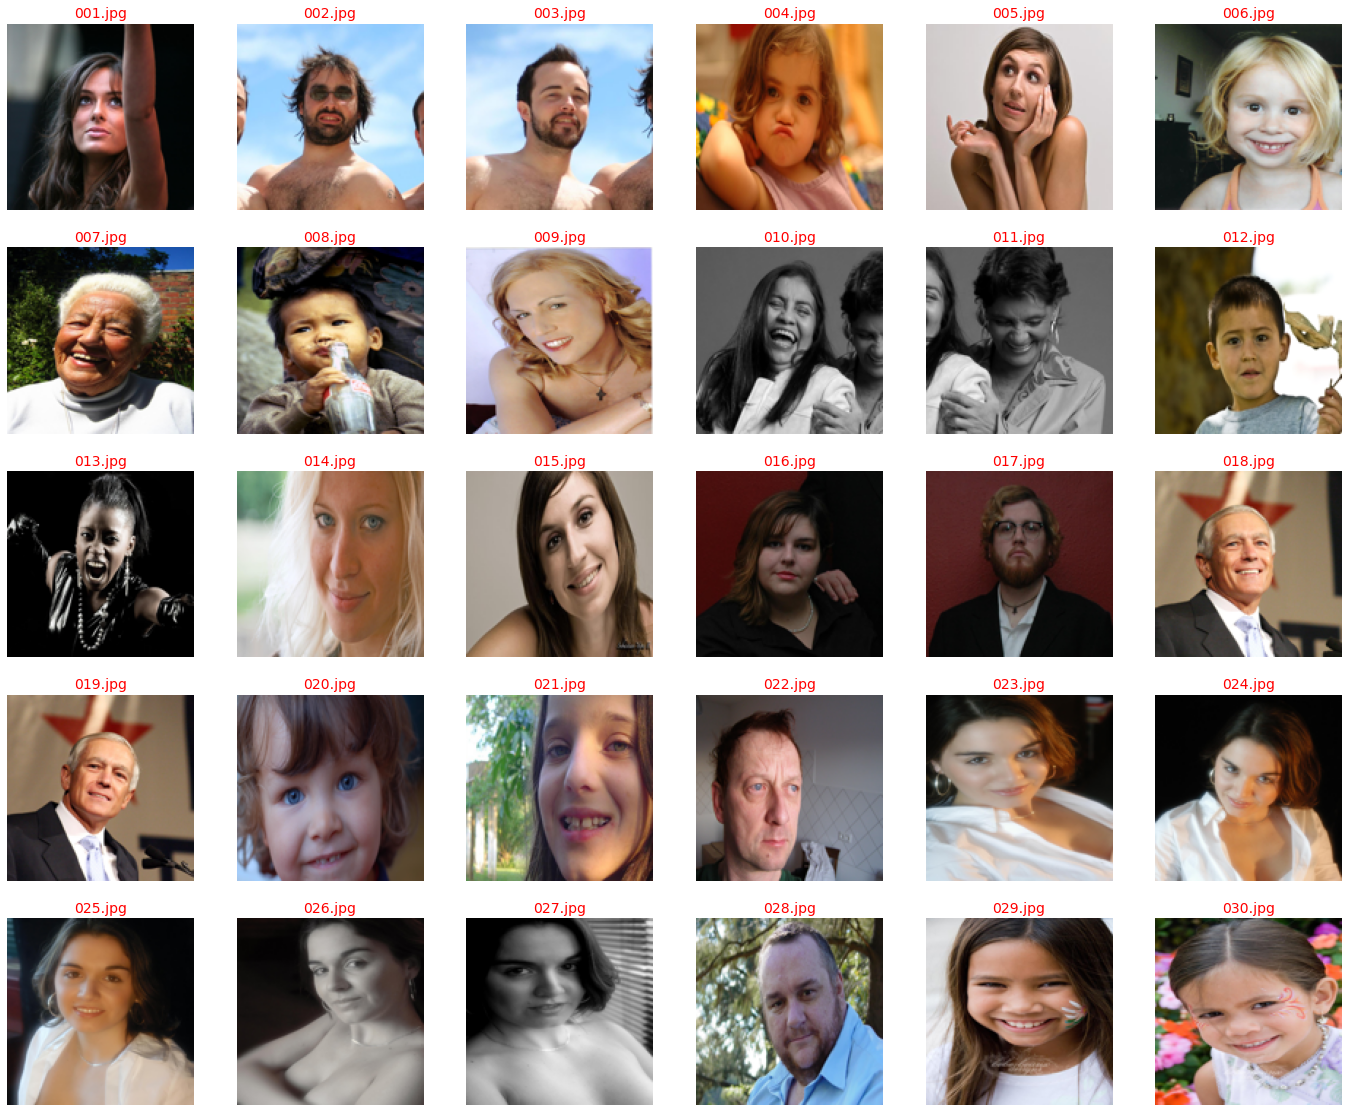

In [6]:
status=row_col_plot(source_dir,30, 6, 128, 128, 'r', 14)

### crop the images

In [8]:
status,uncropped_files_list, to_small_list, no_face_list=crop_image(source_dir, dest_dir,1, 250)


The destination directory contains  76 files
Enter D to delete the files, Q to quit the process or K to keep the files and continued
removing  76  files from  C:\Temp\faces\train_1\cropped


100%|████████████████████████████████████████████████████████████████████████████████| 101/101 [01:21<00:00,  1.24it/s]

The source directory  C:\Temp\faces\train_1  contains sub directories these will be ignored
100 files were processed, 77 cropped images were generated
13 files had cropped images that were below the minimum size and were not saved
['C:\\Temp\\faces\\train_1\\002.jpg', 'C:\\Temp\\faces\\train_1\\003.jpg', 'C:\\Temp\\faces\\train_1\\005.jpg', 'C:\\Temp\\faces\\train_1\\014.jpg', 'C:\\Temp\\faces\\train_1\\037.jpg', 'C:\\Temp\\faces\\train_1\\038.jpg', 'C:\\Temp\\faces\\train_1\\039.jpg', 'C:\\Temp\\faces\\train_1\\040.jpg', 'C:\\Temp\\faces\\train_1\\043.jpg', 'C:\\Temp\\faces\\train_1\\044.jpg', 'C:\\Temp\\faces\\train_1\\053.jpg', 'C:\\Temp\\faces\\train_1\\054.jpg', 'C:\\Temp\\faces\\train_1\\060.jpg', 'C:\\Temp\\faces\\train_1\\064.jpg', 'C:\\Temp\\faces\\train_1\\065.jpg', 'C:\\Temp\\faces\\train_1\\068.jpg', 'C:\\Temp\\faces\\train_1\\069.jpg', 'C:\\Temp\\faces\\train_1\\077.jpg', 'C:\\Temp\\faces\\train_1\\078.jpg', 'C:\\Temp\\faces\\train_1\\079.jpg', 'C:\\Temp\\faces\\train_1\\0

### show some of the cropped results

In [ ]:
if status==True:
    status=row_col_plot(dest_dir,30,6, 128, 128, 'r', 14)